## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import XLNetTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from xlnet import CustomXLNet
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12.3 s, sys: 124 ms, total: 12.4 s
Wall time: 12.7 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_xlnet_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.xlnet, lr / 100, weight_decay)
    )

Fold 1 started at Sat Feb  1 18:49:05 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


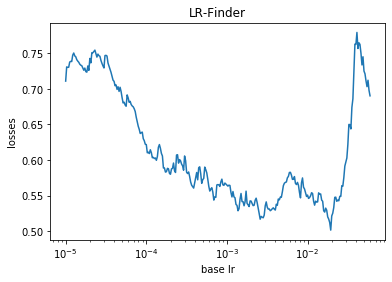

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51465 - spearmanr 0.21679
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47322 - spearmanr 0.37695


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.37695
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46043 - spearmanr 0.38134
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45513 - spearmanr 0.4126
best model: epoch 1 - 0.4126
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43881 - spearmanr 0.44187
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4493 - spearmanr 0.42126
best model: epoch 2 - 0.42126
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41751 - spearmanr 0.49792
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45512 - spearmanr 0.41796
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42126
Starting inference for model: checkpoints/siamese_xlnet_1_fold_1_best.pth



Averaged Val. score: 0.4212640836635016
Starting inference for model: checkpoints/siamese_xlnet_1_fold_1_best.pth



Fold 2 started at Sat Feb  1 20:11:37 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51475 - spearmanr 0.21756
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49035 - spearmanr 0.37849
best model: epoch 0 - 0.37849
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45998 - spearmanr 0.383
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46019 - spearmanr 0.41175
best model: epoch 1 - 0.41175
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43894 - spearmanr 0.44079
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45238 - spearmanr 0.42318
best model: epoch 2 - 0.42318
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4181 - spearmanr 0.49435
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4564 - spearmanr 0.42624
best model: epoch 3 - 0.42624
TRAINING END: Best score achieved on epoch 3 - 0.42624
Starting inference for model: checkpoints/siamese_xlnet_1_fold_2_best.pth



Averaged Val. score: 0.4262382636805294
Starting inference for model: checkpoints/siamese_xlnet_1_fold_2_best.pth



Fold 3 started at Sat Feb  1 21:31:31 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51371 - spearmanr 0.21863
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47032 - spearmanr 0.37583
best model: epoch 0 - 0.37583
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45975 - spearmanr 0.38448
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4601 - spearmanr 0.40012
best model: epoch 1 - 0.40012
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43797 - spearmanr 0.44461
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45369 - spearmanr 0.41017
best model: epoch 2 - 0.41017
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41708 - spearmanr 0.49842
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45742 - spearmanr 0.40879
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41017
Starting inference for model: checkpoints/siamese_xlnet_1_fold_3_best.pth



Averaged Val. score: 0.4101679165939366
Starting inference for model: checkpoints/siamese_xlnet_1_fold_3_best.pth



Fold 4 started at Sat Feb  1 22:50:26 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51409 - spearmanr 0.22331
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47068 - spearmanr 0.36282
best model: epoch 0 - 0.36282
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4593 - spearmanr 0.38551
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45895 - spearmanr 0.39176
best model: epoch 1 - 0.39176
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43788 - spearmanr 0.44618
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4576 - spearmanr 0.39981
best model: epoch 2 - 0.39981
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41617 - spearmanr 0.50171
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45776 - spearmanr 0.40059
best model: epoch 3 - 0.40059
TRAINING END: Best score achieved on epoch 3 - 0.40059
Starting inference for model: checkpoints/siamese_xlnet_1_fold_4_best.pth



Averaged Val. score: 0.4005906074371912
Starting inference for model: checkpoints/siamese_xlnet_1_fold_4_best.pth



Fold 5 started at Sun Feb  2 00:10:06 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5167 - spearmanr 0.21137
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47015 - spearmanr 0.35869
best model: epoch 0 - 0.35869
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46055 - spearmanr 0.38273
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45547 - spearmanr 0.39212
best model: epoch 1 - 0.39212
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43864 - spearmanr 0.4436
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45098 - spearmanr 0.40519
best model: epoch 2 - 0.40519
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41679 - spearmanr 0.50008
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45465 - spearmanr 0.40274
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40519
Starting inference for model: checkpoints/siamese_xlnet_1_fold_5_best.pth



Averaged Val. score: 0.40518555614573376
Starting inference for model: checkpoints/siamese_xlnet_1_fold_5_best.pth



Fold 6 started at Sun Feb  2 01:29:50 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51418 - spearmanr 0.22335
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46547 - spearmanr 0.36404
best model: epoch 0 - 0.36404
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46102 - spearmanr 0.38278
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4499 - spearmanr 0.39476
best model: epoch 1 - 0.39476
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43865 - spearmanr 0.44501
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45118 - spearmanr 0.39482
best model: epoch 2 - 0.39482
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41686 - spearmanr 0.50208
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45442 - spearmanr 0.38944
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39482
Starting inference for model: checkpoints/siamese_xlnet_1_fold_6_best.pth



Averaged Val. score: 0.3948185108930725
Starting inference for model: checkpoints/siamese_xlnet_1_fold_6_best.pth



Fold 7 started at Sun Feb  2 02:49:11 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51311 - spearmanr 0.2209
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49145 - spearmanr 0.37138
best model: epoch 0 - 0.37138
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45964 - spearmanr 0.38285
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46173 - spearmanr 0.40685
best model: epoch 1 - 0.40685
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43844 - spearmanr 0.44131
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4569 - spearmanr 0.41238
best model: epoch 2 - 0.41238
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41696 - spearmanr 0.49754
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45993 - spearmanr 0.41607
best model: epoch 3 - 0.41607
TRAINING END: Best score achieved on epoch 3 - 0.41607
Starting inference for model: checkpoints/siamese_xlnet_1_fold_7_best.pth



Averaged Val. score: 0.416068102088494
Starting inference for model: checkpoints/siamese_xlnet_1_fold_7_best.pth



Fold 8 started at Sun Feb  2 04:08:08 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51211 - spearmanr 0.22548
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47848 - spearmanr 0.38118
best model: epoch 0 - 0.38118
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45878 - spearmanr 0.38335
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46586 - spearmanr 0.4092
best model: epoch 1 - 0.4092
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4369 - spearmanr 0.44578
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46557 - spearmanr 0.41482
best model: epoch 2 - 0.41482
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41522 - spearmanr 0.5014
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46653 - spearmanr 0.41523
best model: epoch 3 - 0.41523
TRAINING END: Best score achieved on epoch 3 - 0.41523
Starting inference for model: checkpoints/siamese_xlnet_1_fold_8_best.pth



Averaged Val. score: 0.41523448678589264
Starting inference for model: checkpoints/siamese_xlnet_1_fold_8_best.pth



Fold 9 started at Sun Feb  2 05:27:08 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51227 - spearmanr 0.2252
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46823 - spearmanr 0.3658
best model: epoch 0 - 0.3658
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45877 - spearmanr 0.38774
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45859 - spearmanr 0.39474
best model: epoch 1 - 0.39474
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43797 - spearmanr 0.44445
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45145 - spearmanr 0.40562
best model: epoch 2 - 0.40562
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41511 - spearmanr 0.50347
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45705 - spearmanr 0.40263
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40562
Starting inference for model: checkpoints/siamese_xlnet_1_fold_9_best.pth



Averaged Val. score: 0.4056160487488693
Starting inference for model: checkpoints/siamese_xlnet_1_fold_9_best.pth



Fold 10 started at Sun Feb  2 06:46:07 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51393 - spearmanr 0.22212
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46544 - spearmanr 0.38389
best model: epoch 0 - 0.38389
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46047 - spearmanr 0.38278
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44751 - spearmanr 0.41318
best model: epoch 1 - 0.41318
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4391 - spearmanr 0.44297
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44691 - spearmanr 0.41937
best model: epoch 2 - 0.41937
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41757 - spearmanr 0.4985
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44923 - spearmanr 0.41611
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41937
Starting inference for model: checkpoints/siamese_xlnet_1_fold_10_best.pth



Averaged Val. score: 0.41937497404271307
Starting inference for model: checkpoints/siamese_xlnet_1_fold_10_best.pth



OOF score: 0.4094500602798917


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomXLNet(256, cat_features_train.shape[1])
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.48002335101992805
5 4 0.4501399205692322
9 64 0.13468600213403914
11 8 0.7545417638331631
12 4 0.5520294962332788
13 4 0.3080292702584956
14 4 0.6280878847756315
15 4 0.5940361680858763
16 16 0.7803027957121355
19 64 0.23937988150206677
24 16 0.1621640152716024


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 64,  8,  4,  4,  4,  4, 16, 64, 16]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19, 24]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.409450
CV unique rows,0.373113
CV ignoring hard targets,0.432907
CV unique rows ignoring hard targets,0.393948
CV w rounding,0.444010
CV unique rows w rounding,0.421356
CV ignoring hard targets w rounding,0.462366
CV unique rows ignoring hard targets w rounding,0.432612


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.413407
CV unique rows,0.377188
CV ignoring hard targets,0.432907
CV unique rows ignoring hard targets,0.393948
CV w rounding,0.444738
CV unique rows w rounding,0.421356
CV ignoring hard targets w rounding,0.462366
CV unique rows ignoring hard targets w rounding,0.432612


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.831723,0.626158,0.354225,0.451987,0.523645,0.427682,0.637058,0.636684,0.695995,0.002567,0.731421,0.779064,0.017167,0.273402,0.002487,0.007552,0.036750,0.068801,0.804813,0.000183,0.851804,0.648584,0.255178,0.775572,0.788936,0.444695,0.006670,0.018857,0.866102,0.756378
1,46,0.479765,0.347625,0.004193,0.671473,0.713982,0.903572,0.395065,0.279590,0.136556,0.006928,0.444578,0.530941,0.002677,0.000576,0.000922,0.007850,0.882059,0.351924,0.082497,0.000097,0.225269,0.789946,0.508444,0.859575,0.893252,0.557115,0.918106,0.331582,0.091055,0.546446
2,70,0.771292,0.753187,0.034028,0.755889,0.844230,0.912524,0.548449,0.418560,0.187819,0.005409,0.226466,0.860541,0.010549,0.047221,0.002989,0.005162,0.124617,0.102339,0.569924,0.000514,0.814167,0.681163,0.353719,0.803768,0.823974,0.543007,0.030544,0.050343,0.806479,0.713871
3,132,0.640130,0.254875,0.004632,0.597895,0.645540,0.850758,0.434205,0.285686,0.255650,0.006725,0.568444,0.093726,0.000864,0.001511,0.000497,0.002621,0.847956,0.285551,0.655624,0.000046,0.435894,0.769981,0.603401,0.852875,0.903238,0.620380,0.862521,0.308910,0.571081,0.545176
4,200,0.782621,0.308171,0.048223,0.724983,0.766688,0.849433,0.643305,0.660783,0.449629,0.010081,0.391631,0.790370,0.006438,0.011521,0.002936,0.042641,0.208656,0.181796,0.667041,0.001332,0.501433,0.731695,0.494740,0.870324,0.873223,0.568042,0.311642,0.271059,0.615261,0.641708


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.864287,0.710182,0.361282,0.650423,0.432488,0.281756,0.687890,0.629932,0.086676,0.005416,0.729980,0.095014,0.229600,0.028594,0.007906,0.293660,0.134079,0.094440,0.466439,0.000840,0.830364,0.924336,0.571583,0.973439,0.966636,0.742189,0.180854,0.097414,0.831799,0.827303
1,0.843531,0.699741,0.050566,0.692945,0.917390,0.680175,0.631286,0.707080,0.412394,0.001298,0.237586,0.115804,0.823128,0.006053,0.815768,0.092137,0.083116,0.059709,0.335333,0.013199,0.796825,0.457131,0.234507,0.653059,0.761840,0.379349,0.032099,0.026894,0.374413,0.756088
2,0.622580,0.330239,0.011355,0.613435,0.758561,0.806248,0.447719,0.268231,0.179435,0.003480,0.380585,0.170742,0.008735,0.005461,0.004059,0.264831,0.684507,0.286730,0.211391,0.000280,0.562895,0.865171,0.619769,0.909452,0.900359,0.695342,0.666956,0.336598,0.619099,0.720004
3,0.839095,0.805598,0.095124,0.871093,0.853306,0.934942,0.582995,0.558899,0.282113,0.001420,0.181979,0.966197,0.028589,0.012237,0.054364,0.032901,0.054407,0.095646,0.384122,0.001833,0.843035,0.897359,0.706846,0.910371,0.925841,0.811596,0.023838,0.090424,0.879995,0.667805
4,0.835749,0.791431,0.002222,0.586081,0.825616,0.884200,0.444591,0.463331,0.273955,0.000331,0.372505,0.615083,0.001120,0.000379,0.000257,0.002050,0.914558,0.341154,0.075350,0.000011,0.830225,0.831110,0.419495,0.892156,0.877315,0.583862,0.911828,0.259833,0.057302,0.720149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.884196,0.567963,0.136433,0.761635,0.642942,0.728047,0.613089,0.666279,0.652625,0.003078,0.585510,0.952238,0.094974,0.447987,0.004487,0.078337,0.009973,0.041986,0.757021,0.004853,0.771660,0.937689,0.764278,0.950227,0.933265,0.783239,0.115635,0.154461,0.926136,0.760197
6075,0.912332,0.292896,0.083143,0.421703,0.494803,0.218729,0.791760,0.806233,0.046275,0.001478,0.707142,0.005342,0.004662,0.004607,0.000668,0.006494,0.812099,0.384533,0.171427,0.000031,0.791747,0.860928,0.546786,0.925894,0.937100,0.632836,0.876132,0.354624,0.236561,0.889647
6076,0.652194,0.437296,0.006507,0.698557,0.730282,0.894443,0.449104,0.368147,0.180673,0.002828,0.466369,0.639947,0.001651,0.000520,0.000490,0.005234,0.879905,0.318054,0.142930,0.000076,0.534713,0.627149,0.416767,0.807839,0.768627,0.396119,0.708221,0.210292,0.495967,0.534685
6077,0.896042,0.760575,0.860784,0.212384,0.158762,0.066359,0.630575,0.759937,0.641135,0.000290,0.958123,0.654418,0.080548,0.040881,0.000775,0.013019,0.010561,0.112003,0.670556,0.000009,0.935100,0.792622,0.642907,0.907224,0.922389,0.697949,0.011606,0.085828,0.850595,0.860455


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.389474
question_body_critical                   0.617992
question_conversational                  0.413728
question_expect_short_answer             0.293254
question_fact_seeking                    0.367900
question_has_commonly_accepted_answer    0.422698
question_interestingness_others          0.359007
question_interestingness_self            0.498347
question_multi_intent                    0.580290
question_not_really_a_question           0.093443
question_opinion_seeking                 0.469081
question_type_choice                     0.740426
question_type_compare                    0.364830
question_type_consequence                0.186667
question_type_definition                 0.361445
question_type_entity                     0.457117
question_type_instructions               0.778173
question_type_procedure                  0.369197
question_type_reason_explanation         0.669323
question_type_spelling                   0.068656


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.068656,3.0
question_not_really_a_question,0.093443,5.0
answer_plausible,0.137132,9.0
answer_relevance,0.159438,9.0
question_type_consequence,0.186667,5.0
answer_well_written,0.215955,9.0
answer_helpful,0.227811,9.0
question_expect_short_answer,0.293254,5.0
answer_type_procedure,0.300548,5.0
answer_satisfaction,0.350379,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

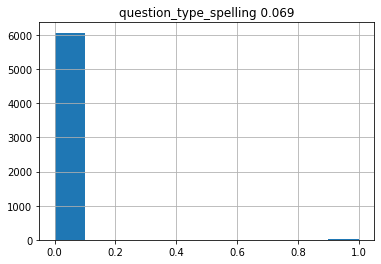

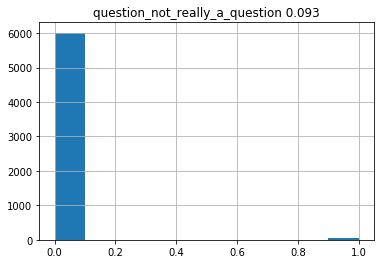

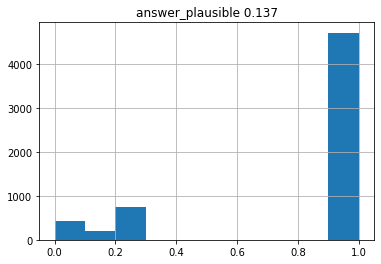

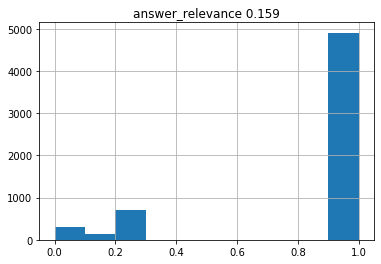

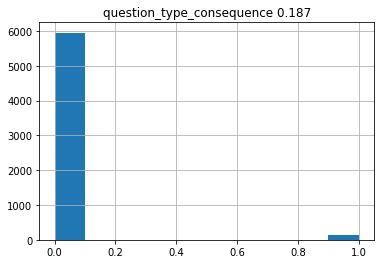

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


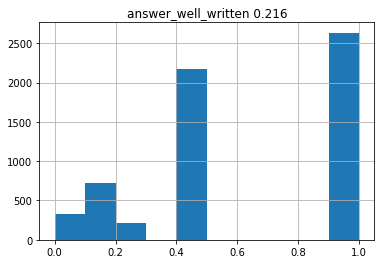

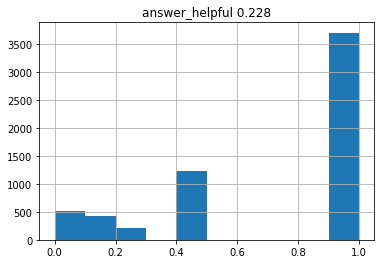

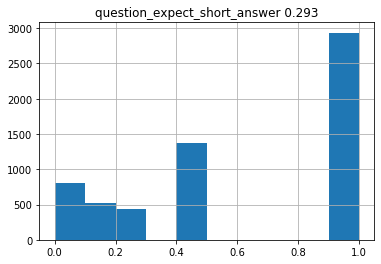

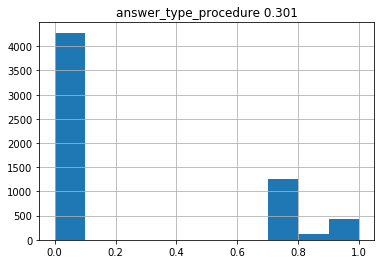

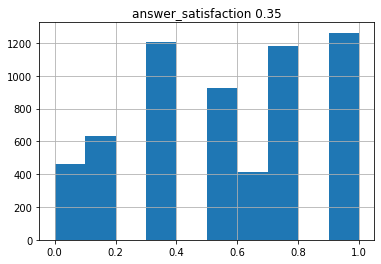

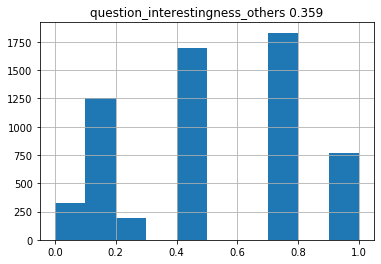

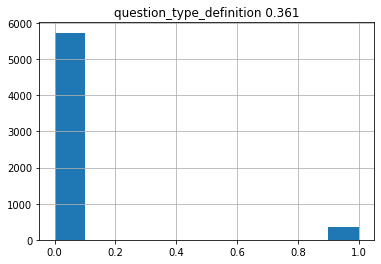

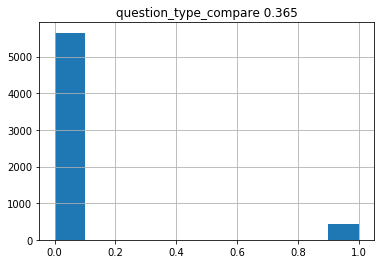

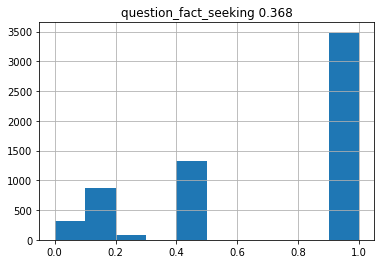

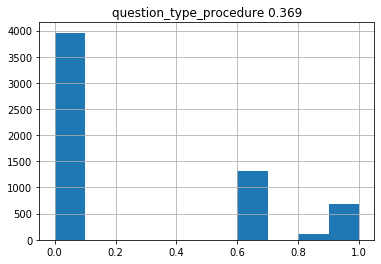

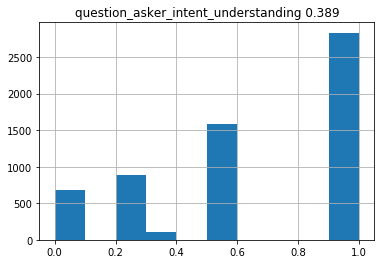

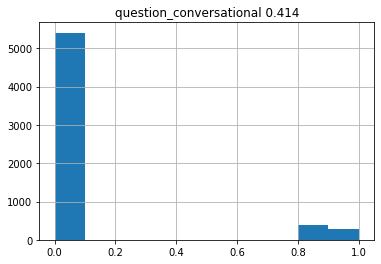

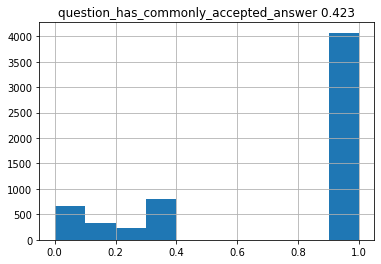

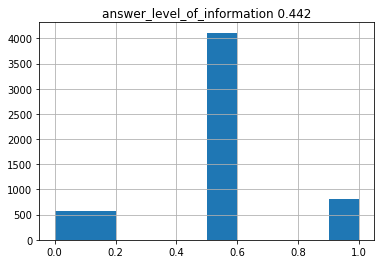

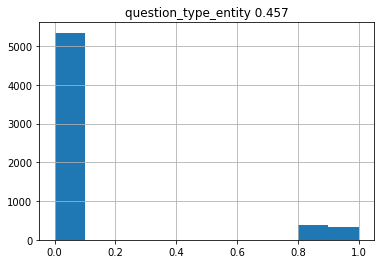

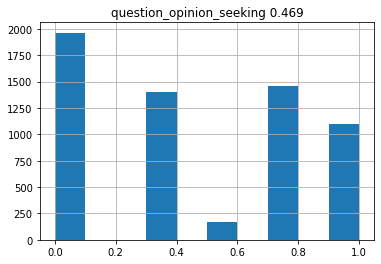

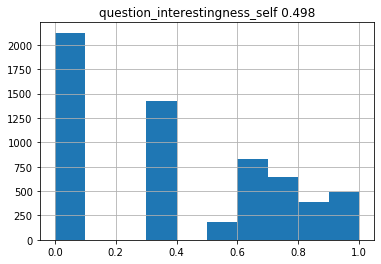

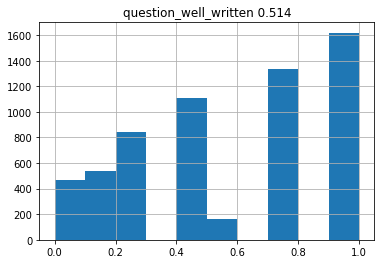

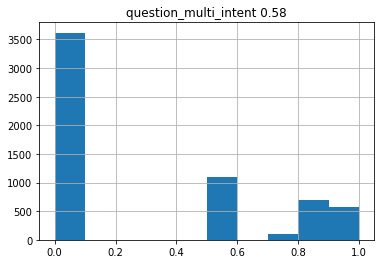

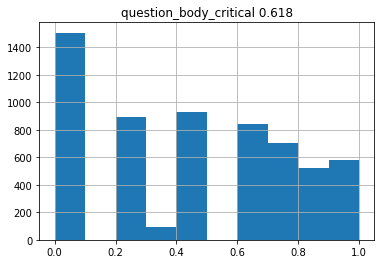

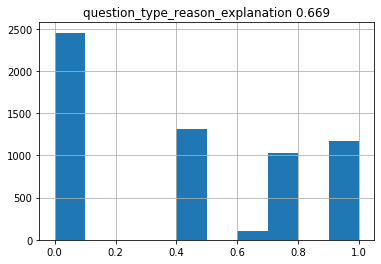

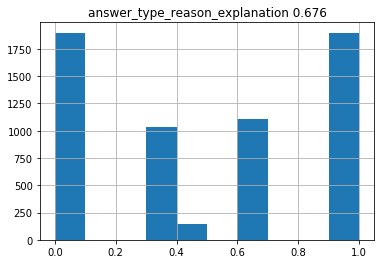

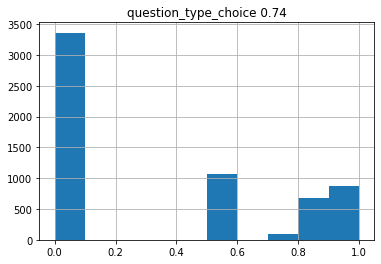

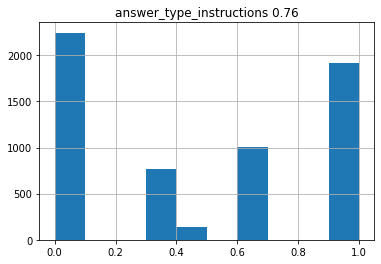

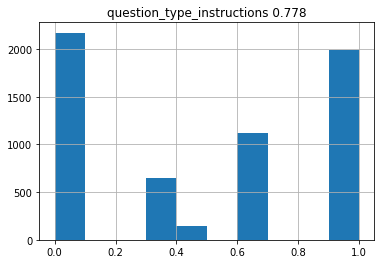

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')